In [1]:
import numpy as np
import cv2

import warnings
warnings.simplefilter(action='ignore')

import pandas as pd
import platform

# Import matplotlib libraries
from matplotlib import pyplot as plt
import seaborn as sns
from matplotlib.collections import LineCollection
import matplotlib.patches as patches

# Some modules to display an animation using imageio.
import imageio
from IPython.display import HTML, display

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import time

In [2]:
if platform.system() == "Darwin":
    root_directory = '/Users/lorenzobarbiero/Documents/GitHub/human_pose'
    data_directory = '/Users/lorenzobarbiero/Desktop/Università/VCS/Human Action Recognition'
else:
    root_directory = ''
    data_directory = '../human_pose_local/archive/Human Action Recognition'

print('root directory is ' + root_directory)
print('data directory is ' + data_directory)

root directory is /Users/lorenzobarbiero/Documents/GitHub/human_pose
data directory is /Users/lorenzobarbiero/Desktop/Università/VCS/Human Action Recognition


### Load the data

In [3]:
file_name = "final_df"

In [4]:
df = pd.read_pickle(data_directory + '/' + file_name + '.pkl')

In [5]:
# apply the function to the dataframe
df['keypoints'] = df['keypoints'].apply(lambda x: np.array(x))
df['object'] = df['object'].apply(lambda x: np.array(x).reshape(-1, 1))
df['obj_vector'] = df['obj_vector'].apply(lambda x: np.array(x))
df['category'] = df['category'].apply(lambda x: np.array(x))

In [6]:
df['obj_input'] = df.apply(lambda x: np.sum(x['object']*x['obj_vector'], axis=0), axis=1)
df['keypoints'] = df['keypoints'].apply(lambda x: x.flatten())

In [7]:
df

,filename,label,category,keypoints,object,obj_label,obj_vector,obj_words,obj_input
0,Image_1.jpg,sitting,11,"[0.06167532131075859, 0.508802056312561, 0.308...","[[0.60480165], [0.04718776], [0.032203343], [0...","[697, 789, 822, 514, 614]","[[-0.28338998556137085, 0.4774399995803833, 0....","[[pajama], [shoji], [steel, drum], [cowboy, bo...","[-0.20592125285495, 0.3260203410991888, -0.008..."
1,Image_2.jpg,using_laptop,14,"[0.2107752561569214, 0.995250403881073, 0.7055...","[[0.7418762], [0.040941585], [0.012892539], [0...","[831, 416, 669, 697, 681]","[[0.3403800129890442, -0.9357600212097168, 1.1...","[[studio, couch], [balance, beam], [mosquito, ...","[0.2683790374652541, -0.6670002713657828, 0.87..."
2,Image_3.jpg,hugging,7,"[0.09106554090976715, 0.47515493631362915, 0.5...","[[0.1416007], [0.13604547], [0.05453948], [0.0...","[697, 522, 984, 529, 416]","[[-0.28338998556137085, 0.4774399995803833, 0....","[[pajama], [croquet, ball], [rapeseed], [diape...","[-0.02030288063444885, 0.23200371996866265, 0...."
3,Image_4.jpg,sleeping,12,"[0.270770400762558, 0.4170025885105133, 0.3047...","[[0.6505104], [0.06191667], [0.027490702], [0....","[678, 691, 680, 529, 823]","[[-1.2170699834823608, -0.12339100241661072, -...","[[neck, brace], [oxygen, mask], [nipple], [dia...","[-0.8215984234954313, -0.02994576481942718, -0..."
4,Image_5.jpg,using_laptop,14,"[0.02712862566113472, 0.23545874655246735, 0.7...","[[0.71057284], [0.10088889], [0.035408325], [0...","[490, 655, 689, 824, 601]","[[-0.1615300178527832, -0.205020010471344, -0....","[[chain, mail], [miniskirt], [overskirt], [sto...","[-0.1494515264241883, -0.1284101833971808, -0...."
...,...,...,...,...,...,...,...,...,...
12595,Image_12596.jpg,sitting,11,"[0.023519866168498993, 0.40524551272392273, 0....","[[0.23895389], [0.14317973], [0.076097175], [0...","[706, 905, 624, 559, 831]","[[-0.399260014295578, 0.13120000064373016, -0....","[[patio], [window, shade], [library], [folding...","[-0.14739882579379793, 0.2794763101199509, -0...."
12596,Image_12597.jpg,clapping,1,"[0.035674747079610825, 0.25097161531448364, 0....","[[0.8603377], [0.021510318], [0.016789775], [0...","[617, 823, 678, 904, 905]","[[0.10435998439788818, 0.29162999987602234, 0....","[[lab, coat], [stethoscope], [neck, brace], [w...","[0.057619909586660134, 0.26067134955875726, 0...."
12597,Image_12598.jpg,sitting,11,"[0.045870888978242874, 0.51141756772995, 0.524...","[[0.48068434], [0.07919033], [0.043129846], [0...","[608, 743, 843, 487, 543]","[[-0.13323000073432922, -0.6275100111961365, -...","[[jean], [prison], [swing], [cellular, telepho...","[-0.001942008389194727, -0.2787240437545768, -..."
12598,Image_12599.jpg,dancing,3,"[0.2243669480085373, 0.4571295976638794, 0.596...","[[0.15199172], [0.068358354], [0.059058633], [...","[416, 615, 747, 617, 587]","[[0.5044400095939636, 0.536300003528595, -0.07...","[[balance, beam], [knee, pad], [punching, bag]...","[0.014005273690095521, 0.06621338508228547, -0..."


In [8]:
def train_test_split_df(df, test_perc): 
    
    n_classes = df['category'].nunique()
    
    n_samples = int(len(df)*test_perc/n_classes)
    
    test_df = df.groupby('category').apply(lambda x: x.sample(n_samples)).reset_index(drop=True)

    # split the dataframe in train and test by the column 'filename'

    train_df = df[~df['filename'].isin(test_df['filename'])]
    
    return train_df, test_df

In [9]:
train_df, test_df = train_test_split_df(df, 0.2)

In [10]:
def create_dataset(df, use_object=True):
    
    labels = df['category']
    
    kpoints = df['keypoints']

    # merge the two arrays
    if use_object:
        df['input'] = df.apply(lambda x: np.concatenate((x['keypoints'], x['obj_input'])), axis=1)
    else:
        df['input'] = df['keypoints']

    if use_object:
        data = np.zeros((len(kpoints), 17*3+100))
    else:    
        data = np.zeros((len(kpoints), 17*3))
    
    for i, row in enumerate(df['input']): 
        data[i,:] = np.array(row)
    
    return data, labels

### GridSearch

In [ ]:
kernel = ['rbf']
C = [8, 10, 12]

In [ ]:
for kr in kernel:
    for c in C:
        print("Fitting SVM")
        print("Kernel", kr)
        print("C", c)
        
        # KFold cross-validation
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

        accuracy_per_fold = []

        for train_index, val_index in kf.split(df):
    
            df_train, df_val = df.iloc[train_index], df.iloc[val_index]
    
            # Convert to TensorFlow datasets
            train_dataset, train_labels = create_dataset(df_train)
            val_dataset, val_labels = create_dataset(df_val)
    
            # Create a new instance of the model
            model = SVC(kernel=kr, C=c)

            # Train the model
            results = model.fit(train_dataset, train_labels)
    
            # compute predicted labels
            predicted_labels = model.predict(val_dataset)
    
            # Evaluate the model
            val_accuracy = accuracy_score(val_labels, predicted_labels)
            accuracy_per_fold.append(val_accuracy)
        
        print("Average accuracy:", np.round(np.mean(accuracy_per_fold),3), "±", np.round(np.std(accuracy_per_fold),3))
        print("---------------------------------------------------------")

### Training on best model

In [11]:
# Number of folds
n_splits = 5

index = 1

# KFold cross-validation
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

accuracy_per_fold = []
conf_matrix = np.zeros((15,15))


for train_index, val_index in kf.split(df, df['category']):
    
    print("Starting Fold Number", index)
    print()
    
    index += 1
    
    df_train, df_val = df.iloc[train_index], df.iloc[val_index]
    
    # Convert to TensorFlow datasets
    train_dataset, train_labels = create_dataset(df_train)
    val_dataset, val_labels = create_dataset(df_val)
    
    print("Fitting the model:")
    
    start = time.time()
    
    # Create a new instance of the model
    model = SVC(kernel='rbf', C=10)

    # Train the model
    results = model.fit(train_dataset, train_labels)

    end = time.time()
    print('Training time:', round(end-start,2), "s")
    
    # compute predicted labels
    predicted_labels = model.predict(val_dataset)
    
    # compute the confusion matrix
    cm = confusion_matrix(val_labels, predicted_labels)
    #print(cm)
    conf_matrix = conf_matrix + cm
    
    # Evaluate the model
    val_accuracy = accuracy_score(val_labels, predicted_labels)
    print("Accuracy:", round(val_accuracy,3))
    accuracy_per_fold.append(val_accuracy)
    
    print()
    print('-----------------------------------------------------------------')
    print()

Starting Fold Number 1

Fitting the model:
Training time: 5.06 s
Accuracy: 0.568

-----------------------------------------------------------------

Starting Fold Number 2

Fitting the model:
Training time: 5.12 s
Accuracy: 0.558

-----------------------------------------------------------------

Starting Fold Number 3

Fitting the model:
Training time: 5.1 s
Accuracy: 0.545

-----------------------------------------------------------------

Starting Fold Number 4

Fitting the model:
Training time: 5.05 s
Accuracy: 0.576

-----------------------------------------------------------------

Starting Fold Number 5

Fitting the model:
Training time: 5.06 s
Accuracy: 0.567

-----------------------------------------------------------------



In [12]:
# get the label from the category
labels = df.groupby('category').first()['label']
labels = np.array(labels).tolist()
labels[9] = 'music'

In [13]:
# Define a function to plot the confusion matrix
def plot_confusion_matrix(cm, threshold=0.1, val=True):
    #normalize cm
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(11, 6))
    if val:
        ax = sns.heatmap(cm_normalized, annot=False, cmap='Greens', vmin=0, vmax=1, cbar=True, xticklabels=labels, yticklabels=labels)
        ax.set_title("SVM - Validation Set")
    else:
        ax = sns.heatmap(cm_normalized, annot=False, cmap='Oranges', vmin=0, vmax=1, cbar=True, xticklabels=labels, yticklabels=labels)
        ax.set_title("SVM - Test Set")
    
    # Annotate only the main diagonal with rounded values
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            if i == j or cm_normalized[i, j] > threshold:
                if cm_normalized[i, j] < 0.7:
                    ax.text(j + 0.5, i + 0.5, f'{cm_normalized[i, j]:.2f}', 
                            ha='center', va='center', color='black', fontsize=14)
                else:
                    ax.text(j + 0.5, i + 0.5, f'{cm_normalized[i, j]:.2f}', 
                            ha='center', va='center', color='white', fontsize=14)    
                
    # Labels, title and axes
    ax.set_xlabel('Predicted labels', fontsize = 14)
    ax.set_ylabel('True labels', fontsize = 14)
    plt.xticks(rotation=60)
    
    plt.show()

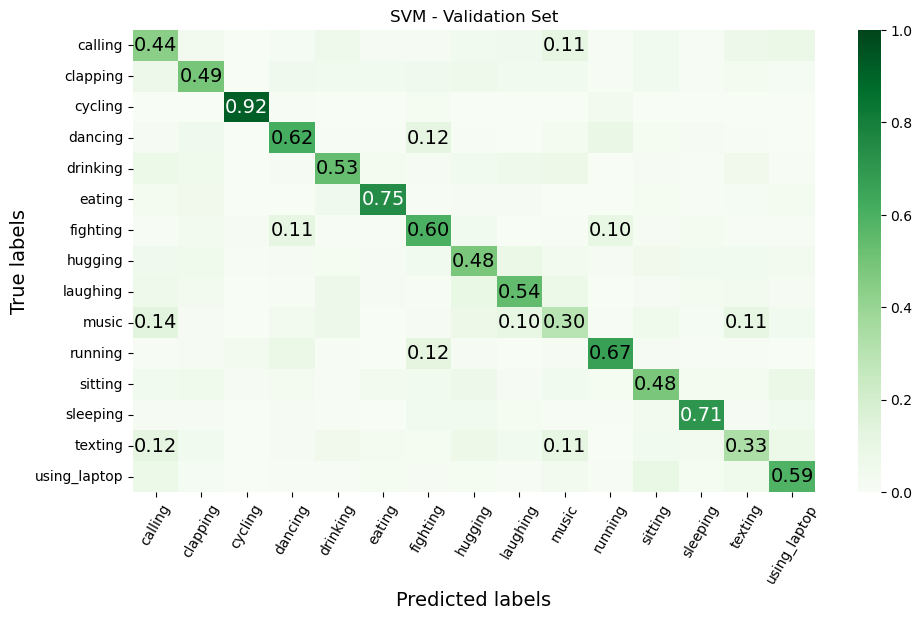

In [14]:
plot_confusion_matrix(conf_matrix)

In [15]:
def class_specific_metrics(cm, class_labels = labels):

    # Initialize dictionaries to hold metrics for each class
    accuracy = {}
    sensitivity = {}
    specificity = {}
    precision = {}

    for idx, label in enumerate(class_labels):
        # True positives
        TP = cm[idx, idx]

        # False positives
        FP = cm[:, idx].sum() - TP

        # False negatives
        FN = cm[idx, :].sum() - TP

        # True negatives
        TN = cm.sum() - (TP + FP + FN)

        # Calculate metrics
        accuracy[label] = (TP + TN) / cm.sum()
        sensitivity[label] = TP / (TP + FN) if (TP + FN) != 0 else 0
        specificity[label] = TN / (TN + FP) if (TN + FP) != 0 else 0
        precision[label] = TP / (TP + FP) if (TP + FP) != 0 else 0

    metrics_dict = {label: {'Accuracy': accuracy[label],
                        'Sensitivity': sensitivity[label],
                        'Specificity': specificity[label],
                        'Precision': precision[label]}
                    for label in class_labels}

    # Convert the dictionary to a pandas DataFrame
    df_metrics = pd.DataFrame.from_dict(metrics_dict, orient='index')
    df_metrics

    return df_metrics

In [16]:
val_metrics = class_specific_metrics(conf_matrix)
val_metrics

,Accuracy,Sensitivity,Specificity,Precision
calling,0.915159,0.438095,0.949235,0.381347
clapping,0.933651,0.492857,0.965136,0.502427
cycling,0.989048,0.915476,0.994303,0.919856
dancing,0.946032,0.615476,0.969643,0.591533
drinking,0.941587,0.533333,0.970748,0.565657
eating,0.967619,0.745238,0.983503,0.763415
fighting,0.936667,0.598810,0.960799,0.521784
hugging,0.925556,0.483333,0.957143,0.446154
laughing,0.939365,0.539286,0.967942,0.545783
music,0.913254,0.300000,0.957058,0.332893


### Test set

In [17]:
train_dataset, train_labels = create_dataset(train_df)

# Create a new instance of the model
model = SVC(kernel='rbf', C=10)

# Train the model
results = model.fit(train_dataset, train_labels)

In [18]:
test_dataset, test_labels = create_dataset(test_df)

In [19]:
# compute predicted labels
predicted_labels = model.predict(test_dataset)
    
# compute the confusion matrix
cm = confusion_matrix(test_labels, predicted_labels)
    
# Evaluate the model
val_accuracy = accuracy_score(test_labels, predicted_labels)
print("Accuracy:", round(val_accuracy,3))

Accuracy: 0.562


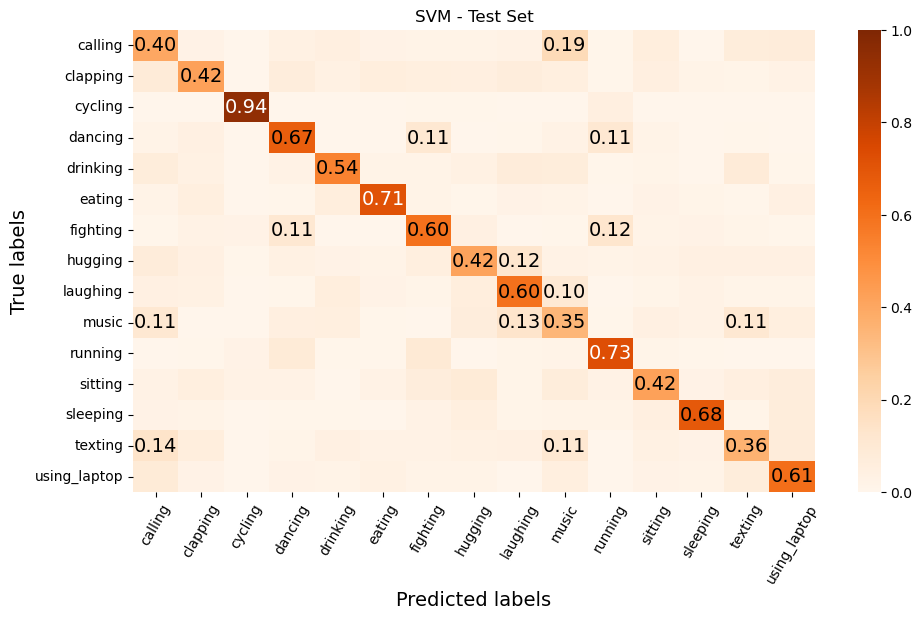

In [20]:
plot_confusion_matrix(cm, val=False)

In [21]:
test_metrics = class_specific_metrics(cm)
test_metrics

,Accuracy,Sensitivity,Specificity,Precision
calling,0.913095,0.398810,0.949830,0.362162
clapping,0.933333,0.422619,0.969813,0.500000
cycling,0.990476,0.940476,0.994048,0.918605
dancing,0.944444,0.666667,0.964286,0.571429
drinking,0.945635,0.535714,0.974915,0.604027
eating,0.964286,0.714286,0.982143,0.740741
fighting,0.938095,0.595238,0.962585,0.531915
hugging,0.929365,0.416667,0.965986,0.466667
laughing,0.937302,0.595238,0.961735,0.526316
music,0.904762,0.345238,0.944728,0.308511
